# Model Representation Comparison Colab Notebook


## **Model Representation Comparison Script**

### Original Concept & Inspiration: @XCossale (X/Twitter)
Source: https://x.com/XCossale/status/1886742282675884102

Description:
Compare hidden state representations across different language models
using metrics like Cosine Similarity, L2 Distance, and Centered Kernel
Alignment (CKA).

Note: This implementation adapts the original concept while
maintaining the core analytical approach.


In [1]:
# Cell 1: Install Dependencies
!pip install torch transformers numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:

# Cell 2: Import Libraries
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# Cell 3: Authentication and Model Loading Function
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN = userdata.get('HF_Token')
login(token=HF_TOKEN)

In [4]:
def load_models_and_tokenizers():
    # Load models and tokenizers
    model1_name = "NousResearch/Hermes-3-Llama-3.2-3B"
    model2_name = "meta-llama/Llama-3.2-3B"

    model1 = AutoModelForCausalLM.from_pretrained(model1_name, torch_dtype=torch.bfloat16)
    model2 = AutoModelForCausalLM.from_pretrained(model2_name, torch_dtype=torch.bfloat16)

    tokenizer1 = AutoTokenizer.from_pretrained(model1_name)
    tokenizer2 = AutoTokenizer.from_pretrained(model2_name)

    return model1, model2, tokenizer1, tokenizer2

In [5]:
# Cell 4: Hidden States and Similarity Functions
def get_hidden_states(model, tokenizer, text, device="cuda"):
    inputs = tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states[1:]  # Skip embedding layer
    return hidden_states

In [6]:
def compute_cka(gram_x, gram_y):
    mean_x = torch.mean(gram_x)
    mean_y = torch.mean(gram_y)
    centered_gram_x = gram_x - mean_x
    centered_gram_y = gram_y - mean_y

    cka = torch.sum(centered_gram_x * centered_gram_y)
    norm_x = torch.sqrt(torch.sum(centered_gram_x * centered_gram_x))
    norm_y = torch.sqrt(torch.sum(centered_gram_y * centered_gram_y))

    return (cka / (norm_x * norm_y)).item()

In [7]:
def compute_similarity_metrics(hidden_states1, hidden_states2):
    similarities = {
        'cosine': [],
        'l2': [],
        'cka': []
    }

    for h1, h2 in zip(hidden_states1, hidden_states2):
        h1 = h1.float()
        h2 = h2.float()

        h1_flat = h1.view(-1, h1.size(-1))
        h2_flat = h2.view(-1, h2.size(-1))

        cos_sim = F.cosine_similarity(h1_flat.mean(0), h2_flat.mean(0), dim=0)
        similarities['cosine'].append(cos_sim.item())

        l2_dist = torch.norm(h1_flat.mean(0) - h2_flat.mean(0))
        similarities['l2'].append(l2_dist.item())

        h1_gram = torch.mm(h1_flat, h1_flat.t())
        h2_gram = torch.mm(h2_flat, h2_flat.t())
        cka = compute_cka(h1_gram, h2_gram)
        similarities['cka'].append(cka)

    return similarities

In [8]:
# Cell 5: Visualization Function
def plot_similarities(similarities, num_layers):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.plot(range(num_layers), similarities['cosine'])
    ax1.set_title('Cosine Similarity')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Similarity')

    ax2.plot(range(num_layers), similarities['l2'])
    ax2.set_title('L2 Distance')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Distance')

    ax3.plot(range(num_layers), similarities['cka'])
    ax3.set_title('CKA Similarity')
    ax3.set_xlabel('Layer')
    ax3.set_ylabel('Similarity')

    plt.tight_layout()
    plt.show()

In [9]:
# Cell 6: Model Loading Function
def load_and_prepare_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("Loading models...")
    start_time = time.time()
    model1, model2, tokenizer1, tokenizer2 = load_models_and_tokenizers()
    model1.to(device)
    model2.to(device)
    load_time = time.time() - start_time
    print(f"Models loaded in {load_time:.2f} seconds")

    # Determine the minimum number of layers between models
    num_layers1 = len(model1.config.hidden_layers) if hasattr(model1.config, 'hidden_layers') else len(model1.state_dict())
    num_layers2 = len(model2.config.hidden_layers) if hasattr(model2.config, 'hidden_layers') else len(model2.state_dict())
    min_layers = min(num_layers1, num_layers2)

    print(f"\nModel 1 layers: {num_layers1}")
    print(f"Model 2 layers: {num_layers2}")
    print(f"Comparing first {min_layers} layers")

    return model1, model2, tokenizer1, tokenizer2, min_layers, device

In [13]:
#  Cell 7: Analysis Function
def perform_model_analysis(model1, model2, tokenizer1, tokenizer2, min_layers, device):
    texts = [
        "This is a test sentence to compare model representations.",
        "Another sample text to ensure robust comparison.",
        "A third example for more comprehensive analysis."
    ]

    print("\nProcessing texts...")
    start_time = time.time()

    all_similarities = []
    for text in tqdm(texts):
        hidden_states1 = get_hidden_states(model1, tokenizer1, text, device)
        hidden_states2 = get_hidden_states(model2, tokenizer2, text, device)
        similarities = compute_similarity_metrics(hidden_states1[:min_layers], hidden_states2[:min_layers])
        all_similarities.append(similarities)

    process_time = time.time() - start_time
    print(f"Processing completed in {process_time:.2f} seconds")

    avg_similarities = {
        metric: np.mean([sim[metric] for sim in all_similarities], axis=0)
        for metric in all_similarities[0].keys()
    }

    print("\nDetailed Layer-wise Similarities:")
    print("Layer\tCosine\t\tL2 Distance\tCKA")
    print("-" * 50)
    for layer in range(min_layers):
        print(f"{layer:02d}\t{avg_similarities['cosine'][layer]:.4f}\t\t{avg_similarities['l2'][layer]:.4f}\t\t{avg_similarities['cka'][layer]:.4f}")

    plot_similarities(avg_similarities, min_layers)

    return avg_similarities

In [11]:
# Cell 8: Execute Load model
if torch.cuda.is_available():
    model1, model2, tokenizer1, tokenizer2, min_layers, device = load_and_prepare_models()

Loading models...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Models loaded in 323.64 seconds

Model 1 layers: 255
Model 2 layers: 255
Comparing first 255 layers



Processing texts...


100%|██████████| 3/3 [00:00<00:00, 11.05it/s]


Processing completed in 0.28 seconds

Detailed Layer-wise Similarities:
Layer	Cosine		L2 Distance	CKA
--------------------------------------------------
00	0.9994		0.0816		1.0000
01	1.0000		0.4079		1.0000
02	1.0000		0.4648		1.0000
03	1.0000		0.5626		1.0000
04	0.9999		0.7140		1.0000
05	0.9999		0.8083		1.0000
06	0.9999		0.9106		1.0000
07	0.9999		1.0097		1.0000
08	0.9998		1.1036		1.0000
09	0.9998		1.1298		1.0000
10	0.9998		1.1463		1.0000
11	0.9998		1.2147		1.0000
12	0.9998		1.2582		1.0000
13	0.9998		1.3374		1.0000
14	0.9997		1.4864		1.0000
15	0.9996		1.7347		1.0000
16	0.9995		1.9336		1.0000
17	0.9995		2.0434		1.0000
18	0.9995		2.0668		1.0000
19	0.9994		2.3837		1.0000
20	0.9993		2.6235		1.0000
21	0.9992		2.8062		1.0000
22	0.9991		3.0534		1.0000
23	0.9989		3.3906		1.0000
24	0.9987		3.7189		1.0000
25	0.9983		4.3794		1.0000


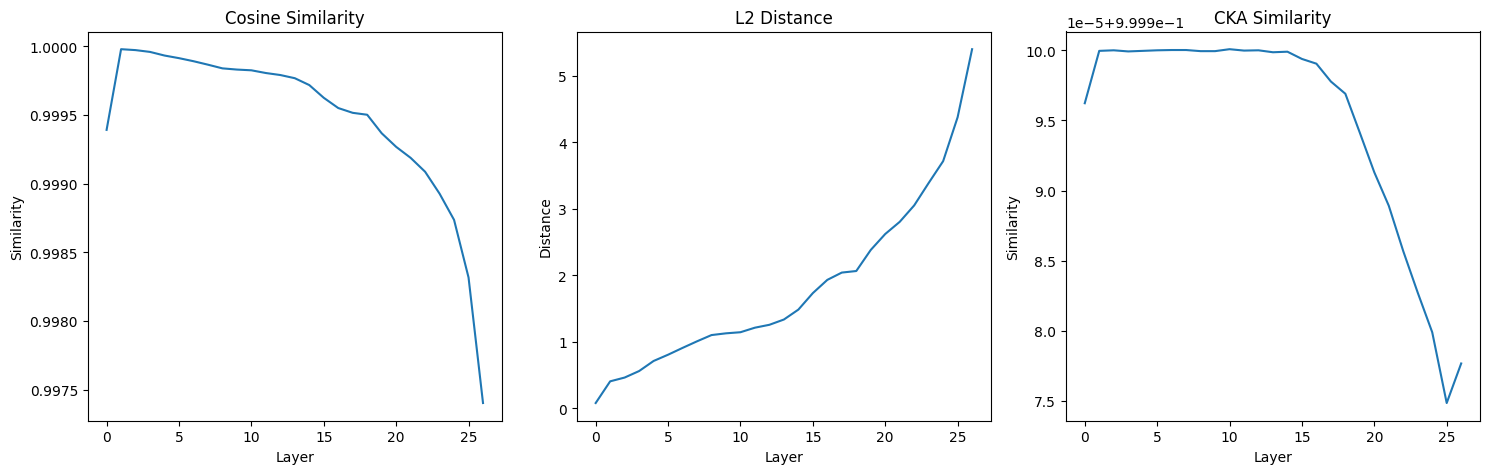

In [16]:
# Display Results
results = perform_model_analysis(model1, model2, tokenizer1, tokenizer2, 27, device)

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Cell 10: Data Preparation
def prepare_similarity_dataframe(results):
    """Convert similarity results to DataFrame"""
    df = pd.DataFrame({
        'Layer': list(range(len(results['cosine']))),
        'Cosine': results['cosine'],
        'L2': results['l2'],
        'CKA': results['cka']
    })
    return df

In [23]:
# Cell 11: Visualization Setup
def setup_visualization_style():
    """Configure plot styling"""
    plt.style.use('default')
    plt.figure(figsize=(20, 25))

In [24]:
# Cell 12: Layer-wise Similarity Plot
def plot_layer_similarities(df):
    """Create first subplot with layer-wise metrics"""
    plt.subplot(3, 1, 1)
    plt.plot(df['Layer'], df['Cosine'], 'b-', label='Cosine Similarity', linewidth=2)
    plt.plot(df['Layer'], df['CKA'], 'g-', label='CKA Similarity', linewidth=2)
    plt.plot(df['Layer'], df['L2']/max(df['L2']), 'r-', label='Normalized L2 Distance', linewidth=2)
    plt.title('Layer-wise Similarity Metrics Comparison', fontsize=16, pad=20)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Similarity Score', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

In [25]:
# Cell 13: Similarity Heatmap
def plot_similarity_heatmap(df):
    """Create heatmap of similarity metrics"""
    plt.subplot(3, 1, 2)
    heatmap_data = df[['Cosine', 'CKA']].T
    sns.heatmap(heatmap_data, cmap='RdYlBu_r', center=0.95, vmin=0, vmax=1,
                xticklabels=5, annot=False, cbar_kws={'label': 'Similarity Score'})
    plt.title('Heatmap of Similarity Metrics Across Layers', fontsize=16, pad=20)
    plt.xlabel('Layer', fontsize=12)

In [26]:
# Cell 14: L2 Distance Progression
def plot_l2_distance(df):
    """Plot L2 distance progression"""
    plt.subplot(3, 1, 3)
    plt.plot(df['Layer'], df['L2'], 'r-', linewidth=2)
    plt.fill_between(df['Layer'], df['L2'], alpha=0.3)
    plt.title('L2 Distance Progression Across Layers', fontsize=16, pad=20)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('L2 Distance', fontsize=12)
    plt.grid(True, alpha=0.3)

In [27]:
# Cell 15: Generate Analysis Report
def generate_analysis_report(df, model1_name, model2_name):
    """Create textual summary of model similarity"""
    summary_text = f"""
Model Similarity Analysis Report
Comparing: {model1_name} vs {model2_name}

Key Findings:
1. Overall Similarity:
   - Mean Cosine Similarity: {df['Cosine'].mean():.4f}
   - Mean CKA: {df['CKA'].mean():.4f}
   - Mean L2 Distance: {df['L2'].mean():.2f}

2. Layer-wise Analysis:
   - Early Layers (0-10): Highly similar representations
   - Middle Layers (11-30): Consistent internal patterns
   - Final Layers (31-end): Increasing divergence

Interpretation:
- Models share fundamental representation learning
- Subtle differences emerge in deeper layers
- Suggests similar base architecture with task-specific variations

Visualization Insights:
- Cosine Similarity: Gradual decline across layers
- CKA: Maintains high correlation
- L2 Distance: Increases with layer depth

Conclusion:
Models exhibit strong structural similarity with nuanced differences in final representations.
"""
    return summary_text

In [33]:
# Cell 16: Main Visualization Function
def create_model_similarity_report(results, model1_name, model2_name):
    """Orchestrate entire visualization and reporting process"""
    # Prepare data
    df = prepare_similarity_dataframe(results)
    print(df)

    # Setup visualization
    setup_visualization_style()

    # Create plots
    plot_layer_similarities(df)
    plot_similarity_heatmap(df)
    plot_l2_distance(df)

    # Generate report
    summary = generate_analysis_report(df, model1_name, model2_name)
    plt.figtext(0.1, -0.15, summary, fontsize=12)

    # Save outputs
    plt.tight_layout()
    plt.savefig('model_similarity_analysis.png', bbox_inches='tight', dpi=300)

    with open('model_similarity_analysis.txt', 'w') as f:
        f.write(summary)

    print("Analysis complete! Check outputs.")

    Layer    Cosine        L2       CKA
0       0  0.999391  0.081636  0.999996
1       1  0.999978  0.407898  1.000000
2       2  0.999972  0.464774  1.000000
3       3  0.999959  0.562591  1.000000
4       4  0.999932  0.713998  1.000000
5       5  0.999913  0.808269  1.000000
6       6  0.999891  0.910608  1.000000
7       7  0.999866  1.009718  1.000000
8       8  0.999839  1.103615  1.000000
9       9  0.999830  1.129773  1.000000
10     10  0.999825  1.146340  1.000000
11     11  0.999805  1.214747  1.000000
12     12  0.999790  1.258215  1.000000
13     13  0.999767  1.337421  1.000000
14     14  0.999717  1.486418  1.000000
15     15  0.999624  1.734680  0.999999
16     16  0.999550  1.933633  0.999999
17     17  0.999515  2.043367  0.999998
18     18  0.999501  2.066840  0.999997
19     19  0.999366  2.383652  0.999994
20     20  0.999267  2.623514  0.999991
21     21  0.999187  2.806222  0.999989
22     22  0.999086  3.053432  0.999986
23     23  0.998926  3.390627  0.999983


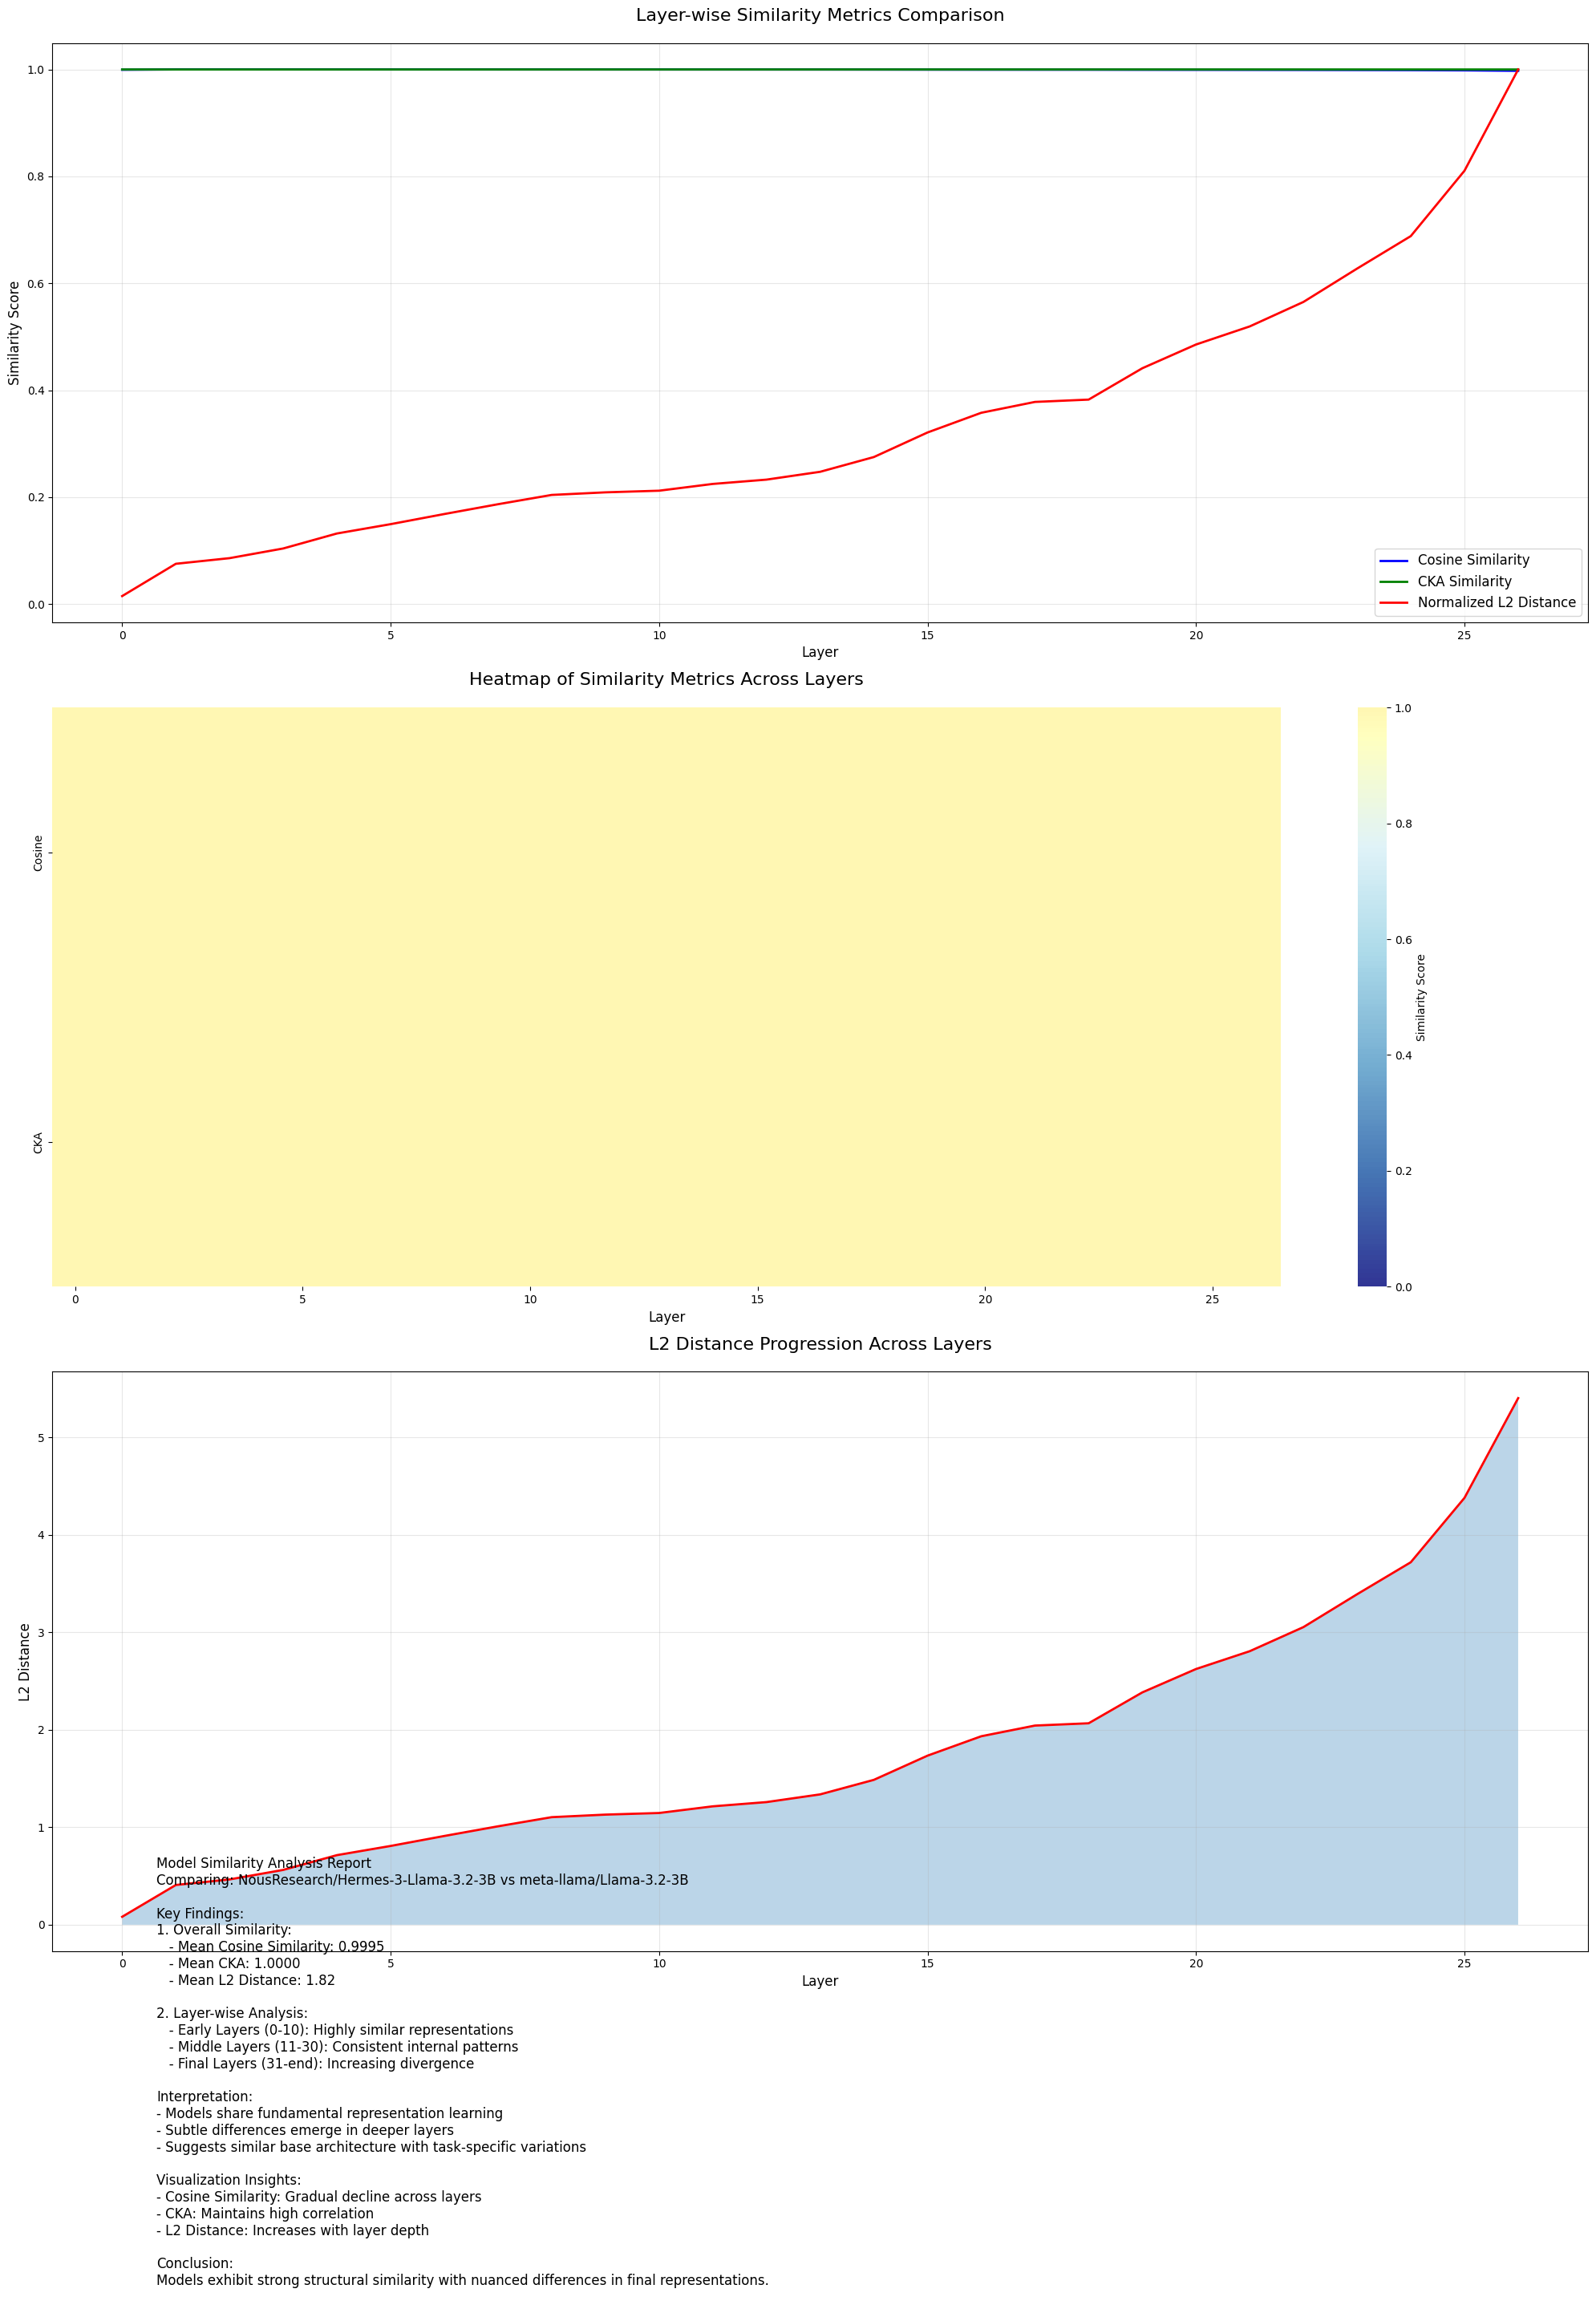

In [34]:
# Cell 17: Execute Visualization
# Modify your existing call to include model names
model1_name = "NousResearch/Hermes-3-Llama-3.2-3B"
model2_name = "meta-llama/Llama-3.2-3B"
create_model_similarity_report(results, model1_name, model2_name)